# PyTorch Feedforward Neural Network for MNLI Dataset

## Basic Information
This implements a simple feed forward neural network, that takes sentence embeddings generated by Sentence-BERT as input.

The premise and hypothesis sentences are converted into their sentence embeddings and the input to the model is the concatenation of the premise embedding, hypothesis embedding and their absolute vector difference. This input was chosen to mirror the input provided to the Sentence-BERT Transformer during its pretraining, in the hopes of maximizing the utility of the sentence embeddings.

The neural network itself contains no hidden layers and uses a softmax classifier on the node output. There are three output nodes for each type of sentence relationship: entailment, neutral or contradiction. The model's predicted relationship for a given sentence pair will be the node with the highest output value.

![Model Diagram](./doc/model_diagram.png?raw=true "Model Diagram")

## Model Imports

In [4]:
# for the sentence transformer
import torch
from sentence_transformers import SentenceTransformer, util

# Imported for the defined FFNN
# All neural network modules
# From simple networks to advanced function
# also includes loss functions
import torch.nn as nn 
# functions that dont have any parameters
# like activation functions and other
import torch.nn.functional as F
# All optimzations algortihms e.g. gradient descent
import torch.optim as optim

# Loading the MNLI dataset
from datasets import load_dataset
import concurrent.futures
import numpy as np
import os

# plots and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

In [4]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Loading the MNLI Dataset

First download the dataset from Hugging Face.

In [5]:
# use the dataset class to download our required dataset
# automatically encoded for us
# 0 : entailment
# 1 : neutral
# 2 : contradiction
data_storage_dir = 'data'
mnli_dataset = load_dataset('glue', 'mnli')
print(mnli_dataset)

Found cached dataset glue (C:/Users/omnic/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 5/5 [00:00<00:00, 25.87it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


Now  split the dataset into training, testing and validation.

In [6]:
total_train_set = mnli_dataset['train']

# need to split because test dataset provided is corrupted (-1 labels)
# use standard 80/20 split
train_set_len = int(0.8*len(total_train_set))
test_set_len = len(total_train_set)-train_set_len
org_train_set, org_test_set = tuple(torch.utils.data.random_split(total_train_set, [ train_set_len, test_set_len ], generator=torch.Generator().manual_seed(42)))

org_val_set = mnli_dataset['validation_matched']

# train_set = org_train_set
# val_set = org_val_set
# test_set = org_test_set

# if sample_dataset:
#     train_set, _  = tuple( torch.utils.data.random_split(org_train_set, [ max_train_samples, len(org_train_set)-max_train_samples ], generator=torch.Generator().manual_seed(42)))
#     val_set, _  = tuple( torch.utils.data.random_split(org_val_set, [ max_val_samples, len(org_val_set)-max_val_samples ], generator=torch.Generator().manual_seed(42)))
#     test_set, _  = tuple( torch.utils.data.random_split(org_test_set, [ max_test_samples, len(org_test_set)-max_test_samples ], generator=torch.Generator().manual_seed(42)))

## Loading The Sentence-BERT Embedding Transformer

The sentence transformer is imported as a simple embedder function that takes a sentence as input, and generates a vector of 384 components as output

In [12]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embedder.encode('Hello World', convert_to_tensor=True)

tensor([-3.4477e-02,  3.1023e-02,  6.7350e-03,  2.6109e-02, -3.9362e-02,
        -1.6030e-01,  6.6924e-02, -6.4415e-03, -4.7451e-02,  1.4759e-02,
         7.0875e-02,  5.5528e-02,  1.9193e-02, -2.6251e-02, -1.0109e-02,
        -2.6940e-02,  2.2307e-02, -2.2227e-02, -1.4969e-01, -1.7493e-02,
         7.6763e-03,  5.4352e-02,  3.2544e-03,  3.1726e-02, -8.4621e-02,
        -2.9406e-02,  5.1596e-02,  4.8124e-02, -3.3148e-03, -5.8279e-02,
         4.1969e-02,  2.2211e-02,  1.2819e-01, -2.2339e-02, -1.1656e-02,
         6.2928e-02, -3.2876e-02, -9.1226e-02, -3.1175e-02,  5.2700e-02,
         4.7035e-02, -8.4203e-02, -3.0056e-02, -2.0745e-02,  9.5178e-03,
        -3.7218e-03,  7.3433e-03,  3.9324e-02,  9.3274e-02, -3.7886e-03,
        -5.2742e-02, -5.8058e-02, -6.8644e-03,  5.2832e-03,  8.2893e-02,
         1.9363e-02,  6.2845e-03, -1.0331e-02,  9.0324e-03, -3.7684e-02,
        -4.5206e-02,  2.4016e-02, -6.9442e-03,  1.3492e-02,  1.0005e-01,
        -7.1684e-02, -2.1695e-02,  3.1618e-02, -5.1

## Preprocessing MNLI Dataset

Preprocessing for the Sentence Pair FFN involves:
- Converting premise sentence to an embeddding
- Converting hypothesis sentence to an embedding
- Cocatenating premise embedding, hypothesis embedding and absolute vector difference of the two embeddings
- Creating one hot encoded vector of 3 components, for network desired output

This is done using a simple function that parses the provided training dataset

In [125]:
def get_network_dim(input=False, output=False):
    # second dimension is 384*3 because generated sentence embeddings are each 384 in length
    # input is ( prem_embedding || hyp_embedding || (prem-hyp) )
    # output is one hot encoded vector 
    return 384*3 if input else 3

def make_x_y_sets(flattened_dataset):
    tr_size = len(flattened_dataset['label'])
    sp_x = torch.zeros( tr_size, get_network_dim(input=True))
    sp_y = torch.zeros( tr_size, get_network_dim(output=True) )

    for i, (prem, hyp, label)in enumerate(zip(flattened_dataset['premise'], flattened_dataset['hypothesis'], flattened_dataset['label'])):
        prem_embedding = embedder.encode(prem, convert_to_tensor=True)
        hyp_embedding = embedder.encode(hyp, convert_to_tensor=True)
        
        sp_x[i] = torch.cat((prem_embedding, hyp_embedding, abs(prem_embedding- hyp_embedding)), 0)
        sp_y[i][label] = 1

    return sp_x, sp_y

    

Added code for parallel preprocessing to speed up data preprocessing times

In [133]:
def parallel_populate(id, raw_dataset):
    # in this case they are given a copy of the dataset from the main function
    #return '{}: Start = {}, End = {}, Size =  {}'.format(id, start, end-1, len(raw_dataset['label']))
    return make_x_y_sets(raw_dataset)

def make_x_y_sets_parallel(raw_dataset, num_threads=4):
    print('Num threads: '+str(num_threads))
    tr_size = len(raw_dataset)
    # second dimension is 384*2 because generated sentence embeddings are each 384 in length
    sp_x = torch.zeros( tr_size, get_network_dim(input=True) )
    sp_y = torch.zeros( tr_size, get_network_dim(output=True) )

    section = int(tr_size/num_threads)
    remainder = tr_size % num_threads

    # print('Section {}'.format(section))
    # print(remainder)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = [ executor.submit(parallel_populate,i, raw_dataset[ i*section : ( (i+1)*section + ( remainder if i+1==num_threads else 0) ) ]) for i in range(num_threads) ]
        
        for i, f in enumerate(results):
            r_x, r_y = f.result()
            start_indx = i*section
            end_indx = ( (i+1)*section + ( remainder if i+1==num_threads else 0) )
            sp_x[start_indx:end_indx] = r_x
            sp_y[start_indx:end_indx] = r_y

    return sp_x, sp_y

Abstracted get dataset code

In [134]:
def save_tensor_to_file(ptensor, fileaddr):
    tndarray = ptensor.numpy()
    print('Saving into {}...'.format(fileaddr))
    np.savetxt(fileaddr, tndarray, delimiter=',')
    print('Done!')

def read_tensor_from_file(fileaddr):
    tndarray = np.genfromtxt(fileaddr, delimiter=',')
    return torch.from_numpy(tndarray)

def get_dataset(split, sample=None, load=False, make=False, num_threads=None):
    if not (load or make):
        raise Exception ('No action provided!')

    split = split.lower()

    if split not in [ 'train', 'test', 'val']:
        raise Exception('Invalid split!')

    made_sets = {
        'train': org_train_set,
        'test': org_test_set,
        'val': org_val_set
    }

    saved_sets = {
        'train': ( 'data/train_x.csv', 'data/train_y.csv' ),
        'test': ( 'data/test_x.csv', 'data/test_y.csv' ),
        'val': ( 'data/val_x.csv', 'data/val_y.csv' )
    }

    if make:
        # requested to make the dataset from the hugging face imports
        dset = made_sets[split]
        if sample is not None:
            # get random sample subset if required
            dset, _  = tuple( torch.utils.data.random_split(made_sets[split], [ sample, len(made_sets[split])-sample ], generator=torch.Generator().manual_seed(42)))
        
        print('Making {} data from hugging face imports....'.format(split))
        # use preprocessing function on the dataset
        return make_x_y_sets_parallel(dset, num_threads=num_threads) if num_threads else make_x_y_sets(dset[:-1])

    if load:
        if sample is not None:
            print('Sampling is not supported for loading datasets')
            
        dx_loc, dy_loc = saved_sets[split]
        if not os.path.exists(dx_loc) or not os.path.exists(dy_loc):
            raise Exception('{} or {} does not exist'.format(dx_loc, dy_loc))
        
        # it does exist so pull the dataset
        print('Loading {} data from "{}" and "{}"....'.format(split, dx_loc, dy_loc))
        dx_set, dy_set = read_tensor_from_file(dx_loc), read_tensor_from_file(dy_loc)

        # sampling for loaded datasets is not supported yet
        return dx_set, dy_set

Additional code to save the preprocessed datasets to file, which can be gotten by using the `load=True` on the get_dataset function. Note that you must save the preprocessed dataset first (as shown in below cell) in ordeer to use the loading feature. (This is deprecated as it was found to have negligible improvements on speed)

In [15]:
save_datasets = False # set to true to save datasets to file
if save_datasets:
    print('Processing training dataset...')
    tr_x, tr_y = get_dataset('train', make=True)
    print('Saving training dataset...')
    save_tensor_to_file(tr_x, 'data/train_x.csv')
    save_tensor_to_file(tr_y, 'data/train_y.csv')

    print('Processing validation dataset...')
    v_x, v_y = get_dataset('val', make=True)
    print('Saving validation dataset...')
    save_tensor_to_file(v_x, 'data/val_x.csv')
    save_tensor_to_file(v_y, 'data/val_y.csv')

    print('Processing testing dataset...')
    te_x, te_y = get_dataset('test', make=True)
    print('Saving testing dataset...')
    save_tensor_to_file(te_x, 'data/test_x.csv')
    save_tensor_to_file(te_y, 'data/test_y.csv')

Configuration for easy loading or making of datasets at specific sizes. The option of using a smaller subset was added as my computer initially struggled with parsing the entire dataset.

In [135]:
config = {
    # set to true to use limited size of the dataset
    # limited size as detailed by keys below
    'sample_dataset': False,
    'train': 1000,
    'val': 100,
    'test': 250,

    # set to true to make dataset from hugging face imports (org train set)
    'make_dataset': False,
    # set to true to load dataset (already preprocessed) from file
    # will only work if datasets have been saved (see above code)
    'load_dataset': True,
}


dataset_sizes= {
    'train': None,
    'val': None,
    'test': None
}

if config['sample_dataset']:
    for key in dataset_sizes:
        dataset_sizes[key] = config[key]

print(dataset_sizes)


{'train': None, 'val': None, 'test': None}


Generating the x and y datasets

In [138]:
sp_train_x, sp_train_y = get_dataset('train', sample=dataset_sizes['train'], make=True, num_threads=4)

Making train data from hugging face imports....
Num threads: 4


In [137]:
sp_test_x, sp_test_y = get_dataset('test', sample=dataset_sizes['test'], make=True, num_threads=4)

Making test data from hugging face imports....
Num threads: 4


In [136]:
sp_val_x, sp_val_y = get_dataset('val', sample=dataset_sizes['val'], make=True, num_threads=4)

Making val data from hugging face imports....
Num threads: 4


In [219]:
print(sp_train_x.shape)
print(sp_test_x.shape)
print(sp_val_x.shape)

torch.Size([314161, 1152])
torch.Size([78541, 1152])
torch.Size([9815, 1152])


## Defining Evaluator and Testing Functions

Plot training history of a model.

In [188]:
def plot_training( network_model ):
    train_accs, val_accs  = network_model.history['train_acc'], network_model.history['val_acc']
    plt.plot(train_accs, label='train_acc')
    plt.title('Model Training History')
    plt.plot(val_accs, label='val_acc')
    plt.legend()
    plt.show()

Evaluator function for the model. It takes desired/actual labels (`y_test`) and compares them against the labels predicted by the model (`y_pred`) to generate:
- Accuracy
- Precision
- Sensitivity
- Specificity
- F1-Measure
- ROC Curves

In [206]:
def make_roc_curves(y_test, y_pred):
    num_classes = y_test.shape[1]

    # roc_data[i][0] = false positive rate for class i
    # roc_data[i][1] = true positive rate for class i
    # roc_data[i][2] = threshold for class i
    roc_data = [ [None, None, None] ] * num_classes

    # get roc data for all classess
    for class_i in range(num_classes):
        # roc_data[i][0] = false positive rate for class i
        # roc_data[i][1] = true positive rate for class i
        # roc_data[i][2] = threshold for class i
        roc_data[class_i][0], roc_data[class_i][1], roc_data[class_i][2] = roc_curve(torch.argmax(y_test, dim=1), y_pred[:, class_i].detach(), pos_label=class_i)
    
    # plot the curves
    for class_i in range(num_classes):
        plt.plot( roc_data[class_i][0], roc_data[class_i][1] ,marker='.')
        plt.title('ROC Curve for Class {}'.format(class_i))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate' )
        plt.show()

def evaluator(y_test, y_pred):
    ####################################################################################################
    # enter code here to implement the evaluation metrics including confusion matrix, accuracy, precision and recall
    # you can only use Numpy or Pytorch to implement the metrics
    ## we will have an array for each of the classes
    num_classes = y_test.shape[1]
    tp = torch.zeros(num_classes)
    tn = torch.zeros(num_classes)
    fp = torch.zeros(num_classes)
    fn = torch.zeros(num_classes)

    # initialize the metrics dictionary
    metrics_dix = {}
    for desired in range(num_classes):
        for pred in range(num_classes):
            metrics_dix[f'{desired}{pred}'] = 0

    # go through incrementing values
    for desired_class, pred_class in zip(torch.argmax(y_test, dim=1) , torch.argmax(y_pred, dim=1)):
        metrics_dix[f'{desired_class}{pred_class}'] += 1

    for class_i in range(num_classes):
        # metrics dix keys are in format of <des><pred>
        # For class i:
        # TP = ii (that is metrics_dix[ii])
        # TN = sum(jj, j:num_classes, j!=i)
        # FP = sum(ji, j:num_classes, j!=i)
        # FN = sum(ij, j:num_classes, j!=i)
        
        # where des=i, pred=i
        tp[class_i] = metrics_dix[f'{class_i}{class_i}']
        
        for class_j in range(num_classes):
            if class_j == class_i: continue
            # TN = sum(jj, j:num_classes, j!=i)
            for class_k in range(num_classes):
                if class_k == class_i: continue
                tn[class_i] += metrics_dix[f'{class_j}{class_k}']

            # FP = sum(ji, j:num_classes, j!=i)
            fp[class_i] += metrics_dix[f'{class_j}{class_i}']
            # FN = sum(ij, j:num_classes, j!=i)
            fn[class_i] += metrics_dix[f'{class_i}{class_j}']
    

    accuracy = (tp.sum()+tn.sum()) / (tp.sum() + tn.sum() + fp.sum() + fn.sum())
    precision = tp.sum() / (tp.sum() + fp.sum())
    recall = tp.sum() / ( tp.sum() + fn.sum())
    specificity = tn.sum() / (tn.sum() + fp.sum())
    f1measure = (2 * precision * recall) / (precision + recall)

    measures = [
        ['Accuracy', accuracy],
        ['Precision', precision],
        ['Sensitivity', recall],
        ['Specificity', specificity],
        ['F1-Measure', f1measure]
    ]

    for m in measures:
        print('{:13} : {:.2f}%'.format(m[0], m[1]*100))

    confusion_matrix = []

    for pred in range(num_classes):
        cur_row = []
        for des in range(num_classes):
            cur_row.append( metrics_dix[f'{des}'f'{pred}'] )
        
        confusion_matrix.append(cur_row)

    row_length = 88
    row_separator = row_length*'-'
    header_row_separator = row_length*'='
    row_format = '{:^7}|'*(num_classes+1)
    matrix_header = []
    for i in range(num_classes):
        matrix_header.append(i)
    matrix_header.insert(0, '')

    print('Confusion Matrix:')

    # print the header row
    print( row_format.format(*tuple(matrix_header)) )
    print(header_row_separator)

    for i in range(num_classes):
        print(row_format.format(*tuple([i] + confusion_matrix[i])))
        print(row_separator)

    print('ROC Curves:')
    make_roc_curves(y_test, y_pred)
        
####################################################################################################

## Feedforward Neural Network Design

The below FFNN code is written in PyTorch and allows for configurable hidden layers, activation/output function and model loss function. This allowed for efficiently testing multiple model variations to find optimum parameters.

In [3]:
class FFNN(nn.Module):
    def __init__(self, input_size, output_size, device, hidden_layers=[], dtype=torch.float32, output_function=nn.Sigmoid()):
        #def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        # hidden_layers is a list that specify the number of nodes in a hidden layer
        # where hidden_layers[0] is between input and first hidden
        # and hidden_layers[-1] is between the last hidden and output

        # intialize using the supper model
        super(FFNN, self).__init__()

        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.device = device
        self.dtype = dtype

        # store training, validation and loss
        self.history = {
            'train_acc': [],
            'val_acc': [],
            'loss': []
        }

        node_to_nodes = [ input_size ] + self.hidden_layers + [ output_size ]

        created_layers = []
        num_nodes = len(node_to_nodes)
        for i in range(0, num_nodes-1):
            # create current layer
            # default nn.Linear includes bias
            new_layer = nn.Linear(node_to_nodes[i], node_to_nodes[i+1])
            # add to list of created layers
            created_layers.append(new_layer)
            
            # add the sigmoid activation function between the layers
            # if i != num_nodes-2: created_layers.append( nn.Sigmoid() )
            #created_layers.append( nn.Softmax(dim=1) )
            created_layers.append( output_function )

            
        # then create model from layer list
        self.network = nn.Sequential( *tuple(created_layers) )

    def forward(self, x_batch ):
        # takes batch of X inputs and calculates the expected output
        # applies torch.argmax
        network_output = self.network( x_batch)
        return network_output

    # create batch function sourced from assigments
    # credits to CMPE 452 TA for original creation
    def createBatches(x, y, batch_size):
        n_epoch = x.shape[0] // batch_size
        for i in range(n_epoch):
            x_batch = x[i * batch_size : (i+1) * batch_size]
            y_batch = y[i * batch_size : (i+1) * batch_size]
            if x_batch.shape[0] > 0:
                yield x_batch, y_batch
        x_batch = x[(i+1) * batch_size:]
        y_batch = y[(i+1) * batch_size:]    
        if x_batch.shape[0] > 0:
                yield x_batch, y_batch

    def predict(self, x_batch):
        return torch.argmax(self(x_batch), dim=1)

    def train(self, train_x, train_y, val_x, val_y, batch_size, learning_rate, num_epochs, lf=nn.MSELoss(), verbose=1):
        #train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

        batches = []
        for b in FFNN.createBatches(train_x, train_y, batch_size):
            batches.append(b)

        # define our loss function and optimization
        loss_function = lf
        # using gradient descent
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            if verbose:
                print('Epoch {}...'.format(epoch+1))
            current_epoch_loss = 0.0
            for i, (batch_inputs, batch_expected_outputs) in enumerate(batches):
                

                # calculate the predicted outputs
                batch_predicted_outputs = self.forward(batch_inputs)

                loss = loss_function(batch_predicted_outputs.float(), batch_expected_outputs.float())

                # compute our gradients
                optimizer.zero_grad()
                #loss.requires_grad = True
                loss.backward()

                # update the weights with our optimization function
                optimizer.step()

                # add the current epoch loss
                current_epoch_loss += loss.item()
                
            # calculate the accuracy and save into history
            y_train_pred = self.predict(train_x)
            y_val_pred = self.predict(val_x)
            train_acc = torch.sum( torch.argmax(train_y, dim=1) == y_train_pred ) / train_x.shape[0]
            val_acc = torch.sum( torch.argmax(val_y, dim=1) == y_val_pred ) / val_x.shape[0]

            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['loss'].append(current_epoch_loss)

            if verbose:
                print('epoch {}, loss {:.4f}, train acc {:.2f}%, validation acc {:.2f}%'.format(
                    epoch + 1, current_epoch_loss, train_acc*100, val_acc*100
                ))

# For some reason, we need subclass for manual batching to work properly
# Did several tests to verify this, if model is created as FFNN object, training will not occur
# Must be object of SentPairNN
class SentPairNN(FFNN):
    def __init__(self, input_size, output_size, device, hidden_layers=[], dtype=torch.float32, output_function=nn.Sigmoid()):

        # intialize using the supper model
        super(SentPairNN, self).__init__(input_size, output_size, device, hidden_layers=[], dtype=dtype, output_function=output_function)

## Model Initialization and Training

Initializing the model:
- Softmax output function
- Cross Entropy Loss

Model training:

In [222]:
sentpair_supreme = SentPairNN(
    384*3, # inputs are the two sentence embeddings
    3, # output is the classification of the items
    device, 
    hidden_layers=[],
    output_function=nn.Softmax(dim=1)
)
sentpair_supreme.train(
    sp_train_x,
    sp_train_y,
    sp_val_x,
    sp_val_y,
    128, # batch size
    0.1, # learning rate
    75, # num epochs
    lf=nn.CrossEntropyLoss()
)

Epoch 1...
epoch 1, loss 2605.9316, train acc 55.99%, validation acc 55.48%
Epoch 2...
epoch 2, loss 2498.0808, train acc 56.40%, validation acc 55.89%
Epoch 3...
epoch 3, loss 2450.2349, train acc 56.67%, validation acc 56.08%
Epoch 4...
epoch 4, loss 2424.1267, train acc 56.88%, validation acc 56.20%
Epoch 5...
epoch 5, loss 2407.4093, train acc 57.06%, validation acc 56.38%
Epoch 6...
epoch 6, loss 2395.5362, train acc 57.24%, validation acc 56.59%
Epoch 7...
epoch 7, loss 2386.4996, train acc 57.40%, validation acc 56.79%
Epoch 8...
epoch 8, loss 2379.2818, train acc 57.54%, validation acc 56.92%
Epoch 9...
epoch 9, loss 2373.3114, train acc 57.67%, validation acc 57.00%
Epoch 10...
epoch 10, loss 2368.2419, train acc 57.77%, validation acc 57.04%
Epoch 11...
epoch 11, loss 2363.8498, train acc 57.89%, validation acc 57.22%
Epoch 12...
epoch 12, loss 2359.9838, train acc 57.98%, validation acc 57.30%
Epoch 13...
epoch 13, loss 2356.5374, train acc 58.06%, validation acc 57.35%
Epoc

## Model Results and Evaluation

Model Training History:

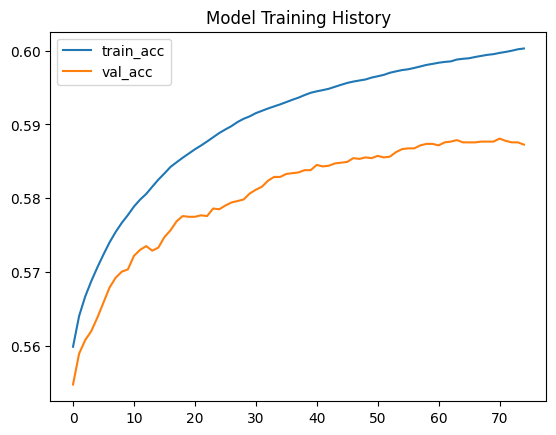

In [223]:
plot_training(sentpair_supreme)

Model testing and evaluation

Accuracy      : 73.20%
Precision     : 59.79%
Sensitivity   : 59.79%
Specificity   : 79.90%
F1-Measure    : 59.79%
Confusion Matrix:
       |   0   |   1   |   2   |
   0   | 18224 | 6737  | 5735  |
----------------------------------------------------------------------------------------
   1   | 5474  | 15627 | 7197  |
----------------------------------------------------------------------------------------
   2   | 2522  | 3914  | 13111 |
----------------------------------------------------------------------------------------
ROC Curves:


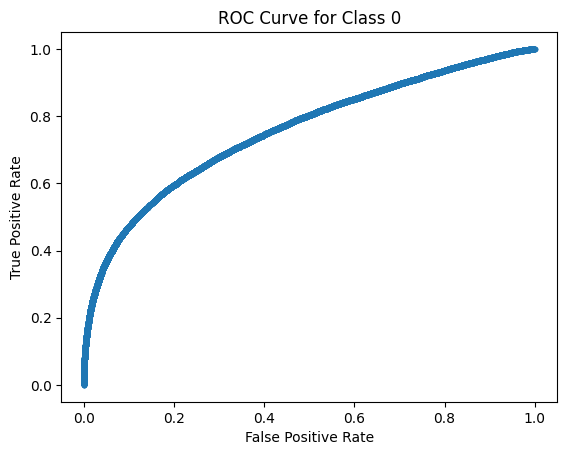

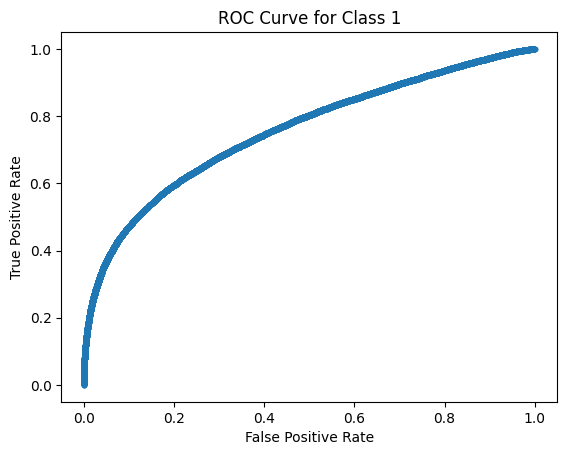

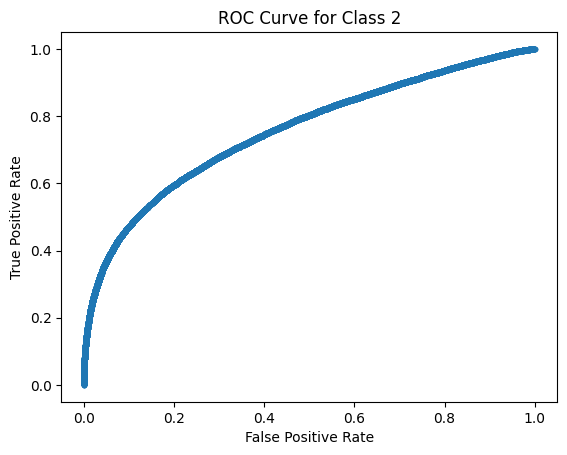

In [224]:
evaluator(sp_test_y, sentpair_supreme(sp_test_x))